## **Clustering**
Having cleaned and filtered our dataset, we narrowed our focus to high consumers defined as those whose bill amounts fall in the 90th percentile and above.

This focus is significant because, after consulting experts at the Nairobi Water Company, we learned that the most common driver of water loss is unbilled water. Despite widespread metering across the city, several structural challenges undermine accurate billing:

- **Busted pipes** – Water lost through leaks in the distribution network is never captured by meters, resulting in substantial unaccounted-for volumes.

- **Damaged metering systems** – When meters fail, all consumption during the downtime goes unbilled, creating revenue gaps.

- **Manual meter reading** – The reliance on manual readings introduces inefficiencies: human error in recording, skipped households or businesses, and overlooked regions. Together, these factors compound the issue of Non-Revenue Water (NRW).

To address this, the project seeks to identify hotspots of water loss and support the strategic rollout of smart metering systems. Clustering provides a powerful approach to this challenge.

By grouping high consumers into three distinct clusters, we can prioritize intervention:

- Highest consumers – the top priority for smart meter rollout, as losses here have the greatest financial impact.

- Higher consumers – secondary priority, important for scaling future rollouts.

- High consumers – still significant but not immediate rollout candidates.

Clustering is an unsupervised machine learning method that automatically groups similar data points without predefined labels. In this project, clustering not only segments consumers into the tiers above but also helps highlight outliers and reveal hidden usage patterns, both of which are critical for detecting leakages, theft, or under-billing risks

In [6]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
RANDOM_STATE = 42


Water billing example:

Normal: Usage is standard to bill.

Under-billed: High usage, low bill.

Over-billed: Low usage, high bill.


In [ ]:
# Load dataset
df = pd.read_csv('../../Data/clean_data/Filtered.csv')

# Preview dataset
df.head()

,Unnamed: 0,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,METER_SIZE,BILL_ESTIMATE_ACTUAL,BILL_VALID_INVALID,MAIN_SERVICE,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,NEGATIVE
0,8,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000010,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,7771.0,0.0,7771.0,111.0,August,2024.0,False
1,11,KASARANI,HUNTERS -MWIKI,HUNTERS,CV-7000013,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,6424.0,0.0,6424.0,91.0,August,2024.0,False
2,39,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000027,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4904.0,3127.0,8031.0,71.0,August,2024.0,False
3,46,LANGATA,KAREN_LANGATA,OTIENDE LANGATA,CV-7000034,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4162.0,2716.0,6878.0,62.0,August,2024.0,False
4,56,DAGORETTI,KAWANGWARE,RIARA,CV-7000116,COM,COMMERCIAL,2.0,ACTUAL,VALID,WAT,SEW,61550.0,40458.0,102008.0,785.0,August,2024.0,False


### **Feature Selection**
Feature selection is the act of choosing the most important variables for a model. It helps improve accuracy, reduce complexity, and also avoid overfitting. At the moment we have 19 columns but to carry out our clustering, we need columns that are relevant to our question and that will help us reach the best possible answer.

We are using the following columns;
1. `WATER_AMOUNT` → this is the direct measure of consumption. Critical.

2. `SEWER_AMOUNT` → this often correlates with water usage. Could be included, but might be redundant (we'll look out for multicollinearity).

3. `BILL_AMOUNT` → how much they’re billed. Tied to water + tariffs.

4. `BILL_VOLUME` → this is another consumption proxy. If strongly correlated with WATER_AMOUNT, you might drop one to avoid redundancy.

5. `METER_SIZE` → capacity, a proxy for expected usage. Very valuable

First, to make sure we have no redundacies, we are filtering the data to have the above named columns then checking for correlation.

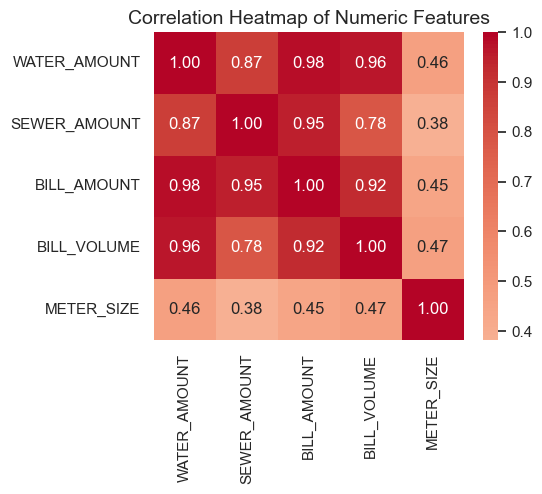

In [8]:
# Filter to remain with the above columns
clustering_data = df[['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']]

# Check correlation
num_cols = ['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'METER_SIZE']

# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

From the visualization above, we see that `WATER_AMOUNT`, `SEWER_AMOUNT`, `BILL_AMOUNT` and `BILL_VOLUME` are highly correlated with all of them having correlations above 85%. To pinpoint exactly where the multicollinearity comes from, we are using VIF (Variance Inflation Factor). 

While correlation tells us what pairs of features are similar, VIF will help us decide which ones to actually keep for clustering.

In [ ]:
# drop NaNs if any
X = df[num_cols].dropna()

# add constant for VIF calculation
X_const = add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print(vif_data)

        Feature            VIF
0  WATER_AMOUNT   86117.235558
1  SEWER_AMOUNT   30230.987080
2   BILL_AMOUNT  205408.686340
3   BILL_VOLUME      14.974460
4    METER_SIZE       1.283845


- `BILL_AMOUNT`, `WATER_AMOUNT`, and `SEWER_AMOUNT` are almost the same information, they’re strongly derived from each other, since `BILL_AMOUNT` = `WATER_AMOUNT` + `SEWER_AMOUNT`.

- Also, `BILL_VOLUME` is somewhat correlated with the billing amounts since cost is tied to consumption, but it still contains unique info about actual consumption.

- `METER_SIZE` is independent and safe.

For clustering, we need features that:

- Aren’t redundant,

- Capture meaningful variation,

- Don’t distort distances due to duplication.

So we are using;

- `BILL_VOLUME` → consumption behavior (core driver of clustering).

- `METER_SIZE` → capacity/size of installation, different customer classes.

- `BILL_AMOUNT` → this will help us have clusters influenced by spending patterns.

### **KMeans Clustering**
In this section we are going to cluster the data using the KMean clustering function based on the features we've chosen above. Clustering will help us find groups of consumers that share patterns. This process is going to involve;
- choosing the best number of clusters

- run KMeans 

- add the cluster labels back to the original data

- interpret what each cluster means

But first, for our baseline model and for easy interpretation, we are using the `BILL_AMOUNT` column to cluster first.

In [9]:
# Using one column for our baseline model
X = df[["BILL_AMOUNT"]]

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Cluster
kmeans = KMeans(random_state=42)

# Predict the clusters
clusters = kmeans.fit_predict(X_scaled)

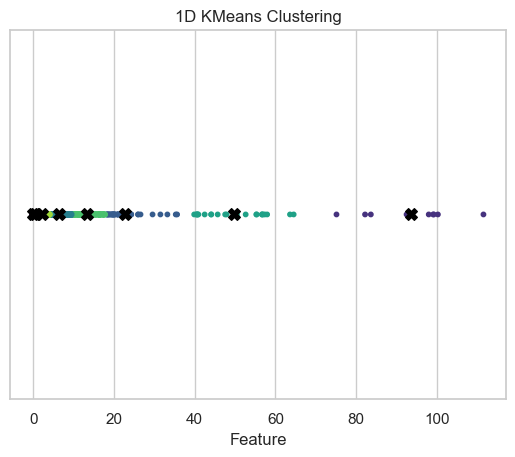

In [11]:
# Plot the clusters
centers = kmeans.cluster_centers_

# Plot the data on the x-axis, and just put zeros on y-axis
plt.scatter(X_scaled[:, 0], [0]*len(X_scaled), c=clusters, s=10, cmap='viridis')

# Plot the centers on the same line
plt.scatter(centers[:, 0], [0]*len(centers), c='black', s=70, marker='X')

plt.yticks([])  # hide y-axis ticks
plt.xlabel("Feature")
plt.title("1D KMeans Clustering")
plt.show()

Most data values cluster between 0–40, showing the main group.

Smaller clusters at higher values reveal outliers

#### Choosing the best number of clusters.
In this part we'll be trying multiple values of k, that is number of clusters, and plot the inertia, how tight the groups are. We want a point where adding more clusters doesn't help much, this is the elbow method.

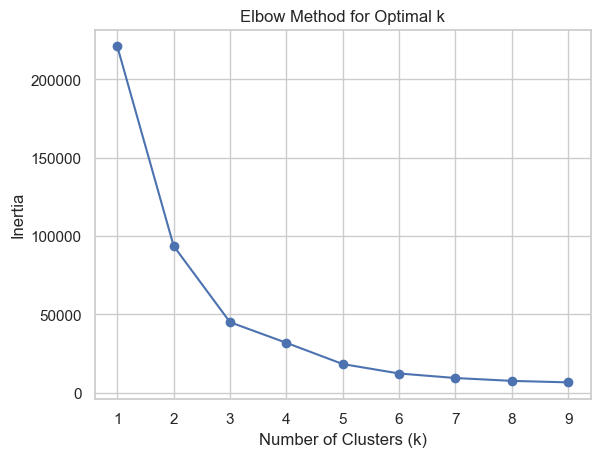

In [55]:
# Choose the best number of clusters.
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

The curve bends at k=3, forming an “elbow.”

This indicates k=3 gives the best balance of accuracy and simplicity.

In [56]:
# Instantiate KMeans model, using the best n_clusters value as indicated by the plot above
kmeans = KMeans(n_clusters= 3, random_state= 42)

# Fit the model on  scaled data
kmeans.fit(X_scaled)

kmeans

KMeans(n_clusters=3, random_state=42)

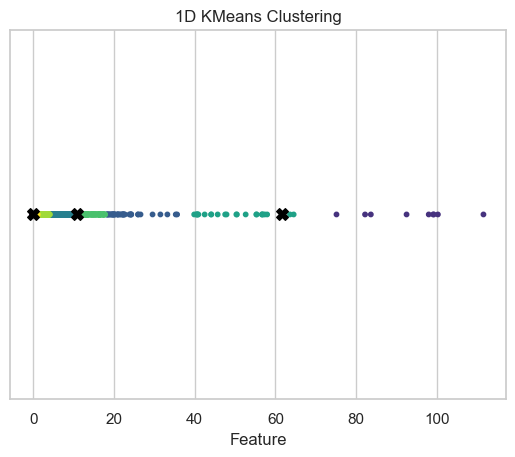

In [57]:
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_

# Plot your data on the x-axis, and just put zeros on y-axis
plt.scatter(X_scaled[:, 0], [0]*len(X_scaled), c=clusters, s=10, cmap='viridis')

# Plot the centers on the same line
plt.scatter(centers[:, 0], [0]*len(centers), c='black', s=70, marker='X')

plt.yticks([])  # hide y-axis ticks
plt.xlabel("Feature")
plt.title("1D KMeans Clustering")
plt.show()

The plot shows:
Black crosses mark the cluster centers along the feature axis (0 to 100+).

Clusters are mostly concentrated at lower feature values, with some sparse points at higher values.

In [58]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [59]:
labels = kmeans.labels_

In [60]:
calinski_harabasz_score(X_scaled, labels)

432076.7718642293

k=2, Calinski-Harabasz Score=300534.11
k=3, Calinski-Harabasz Score=432076.77
k=4, Calinski-Harabasz Score=437241.52
k=5, Calinski-Harabasz Score=611452.53
k=6, Calinski-Harabasz Score=750971.03
k=7, Calinski-Harabasz Score=828827.67
k=8, Calinski-Harabasz Score=889723.54
k=9, Calinski-Harabasz Score=894139.43
k=10, Calinski-Harabasz Score=951814.31


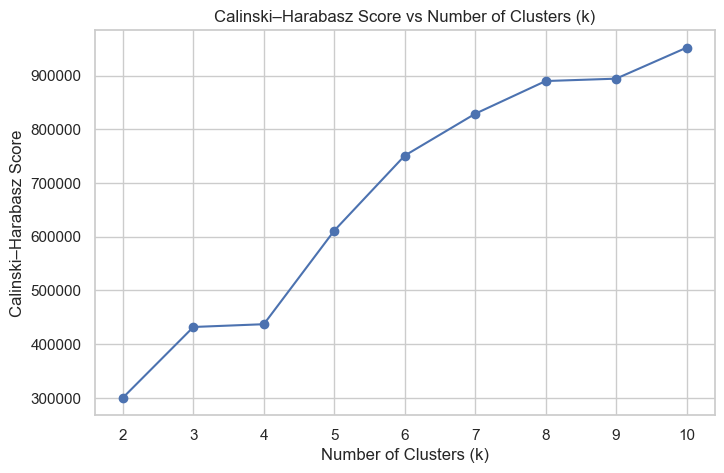

In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# Range of cluster numbers to test
k_values = range(2, 11)
scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, clusters)
    scores.append(score)
    print(f"k={k}, Calinski-Harabasz Score={score:.2f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o')
plt.title("Calinski–Harabasz Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski–Harabasz Score")
plt.grid(True)
plt.show()


The plot helps you identify the optimal number of clusters by showing where the CH score is highest.

In [62]:
# Clustering based on bill amount, water amount, sewer amount and bill volume
X_clusters = df[['BILL_AMOUNT', 'BILL_VOLUME', 'SEWER_AMOUNT', 'WATER_AMOUNT']]

# preview the dataset
X_clusters.head(3)

,BILL_AMOUNT,BILL_VOLUME,SEWER_AMOUNT,WATER_AMOUNT
0,7771.0,111.0,0.0,7771.0
1,6424.0,91.0,0.0,6424.0
2,8031.0,71.0,3127.0,4904.0


In [63]:
# Scale data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_clusters)

In [64]:
# Apply PCA
# Import relevant class
from sklearn.decomposition import PCA

# Create a PCA object
pca_transformer = PCA(n_components= 0.95, random_state= 42)

# Transform data using pca_transformer
pca_data = pca_transformer.fit_transform(X_scaled)
pca_data

array([[-0.2373756 , -0.04582204],
       [-0.25582808, -0.03489988],
       [-0.23980268,  0.01795537],
       ...,
       [-0.17960021,  0.01922132],
       [-0.01244967,  0.03071256],
       [ 0.77485704,  0.09655245]])

In [65]:
kmeans = KMeans(random_state= 42)
labels = kmeans.fit_predict(pca_data)



In [66]:
clusters = kmeans.transform(pca_data)

clusters

array([[1.18217821e-01, 1.78598206e+02, 1.03924207e+01, ...,
        2.35634479e+00, 2.98664372e+01, 4.99668637e+01],
       [1.31447774e-01, 1.78615557e+02, 1.04111933e+01, ...,
        2.37438513e+00, 2.98837729e+01, 4.99882892e+01],
       [1.10144569e-01, 1.78594670e+02, 1.03969278e+01, ...,
        2.35714339e+00, 2.98628704e+01, 5.00035893e+01],
       ...,
       [5.12531012e-02, 1.78534611e+02, 1.03368094e+01, ...,
        2.29693014e+00, 2.98028103e+01, 4.99537884e+01],
       [1.20863659e-01, 1.78367117e+02, 1.01701964e+01, ...,
        2.12967744e+00, 2.96353153e+01, 4.98199973e+01],
       [9.09977809e-01, 1.77577101e+02, 9.38642164e+00, ...,
        1.34325823e+00, 2.88452989e+01, 4.91990986e+01]])

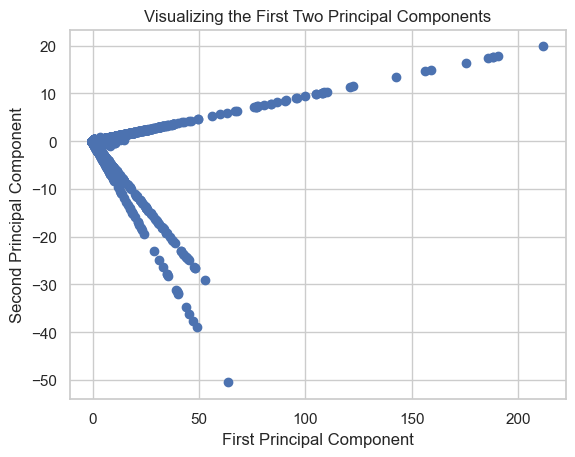

In [67]:

fig, ax = plt.subplots()
ax.scatter(x=pca_data[:, 0], y=pca_data[:, 1])
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title("Visualizing the First Two Principal Components");

The plot shows a 2D projection of your dataset where the axes represent the two most informative directions (principal components).

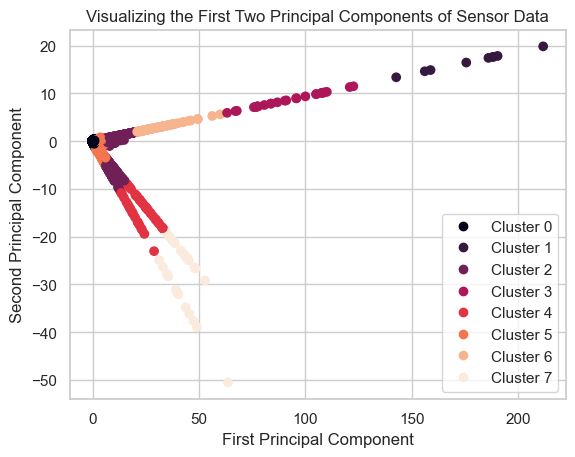

In [68]:
cluster_labels = kmeans.labels_

fig, ax = plt.subplots()

# Modify the below line of code to specify the color:
scatter = ax.scatter(x=pca_data[:, 0], y=pca_data[:, 1], c= cluster_labels)


ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title("Visualizing the First Two Principal Components of Sensor Data")

ax.legend(*scatter.legend_elements(fmt="Cluster {x:.0f}"));

If clusters are well-separated, you’ll see distinct groups.

Overlaps indicate clusters that are less clearly separated.

This is a 2D representation of your high-dimensional clustering, which helps to visually inspect patterns or outliers

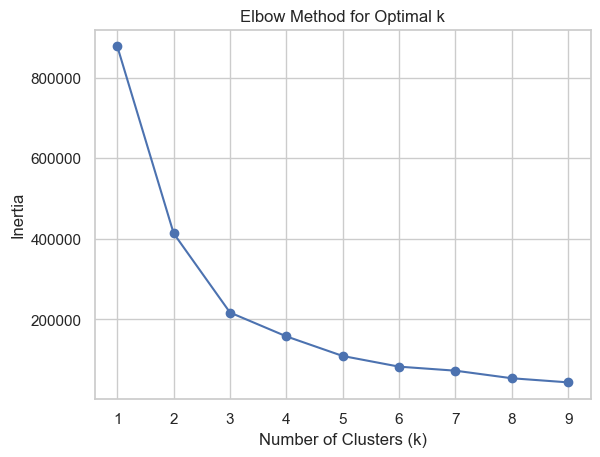

In [69]:
# Choose the best number of clusters.
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

If the plot drops sharply from k=1 to k=3 and then flattens, k=3 is likely the best number of clusters.

Choosing too few clusters can underfit (miss patterns), too many clusters can overfit (split natural groups unnecessarily).

In [70]:
kmeans = KMeans(n_clusters= 3, random_state= 42)
labels = kmeans.fit_predict(pca_data)


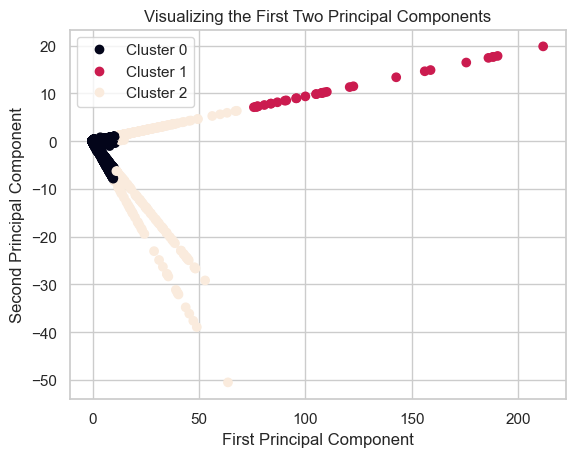

In [71]:
cluster_labels = kmeans.labels_

fig, ax = plt.subplots()

# Modify the below line of code to specify the color:
scatter = ax.scatter(x=pca_data[:, 0], y=pca_data[:, 1], c= cluster_labels)


ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")
ax.set_title("Visualizing the First Two Principal Components")

ax.legend(*scatter.legend_elements(fmt="Cluster {x:.0f}"));

Well-separated colors indicate clear clusters; overlaps indicate clusters that are not strongly separated.

   k  Calinski-Harabasz  Silhouette  Davies-Bouldin
0  2       22667.079677    0.868462        1.032466
1  3       10875.728971    0.478749        1.063196
2  4        7644.202318    0.311486        1.054537
3  5        4845.811372    0.270202        1.060323
4  6       23865.124064    0.317349        0.901623
5  7       20609.832145    0.322550        0.962739
6  8       16723.254304    0.375004        0.922850
7  9       17408.506644    0.502411        0.819703


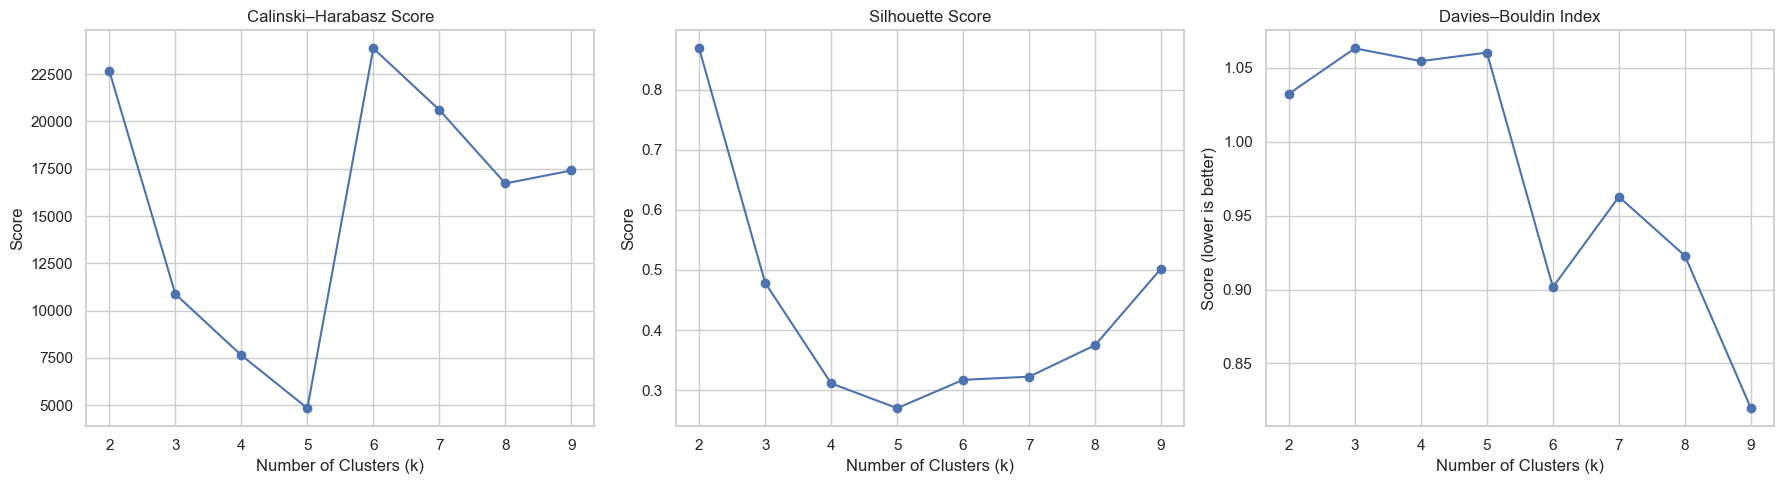

In [72]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

results = []

# loop through k values
for k in range(2, 10):   # adjust range as needed
    # Faster KMeans
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    clusters = kmeans.fit_predict(X_scaled)

    # Metrics
    ch_score = calinski_harabasz_score(X_scaled, clusters)
    db_score = davies_bouldin_score(X_scaled, clusters)

    # Sample for silhouette (fast)
    if X_scaled.shape[0] > 2000:  # only sample if dataset is large
        sample_idx = np.random.choice(len(X_scaled), size=2000, replace=False)
        sil_score = silhouette_score(X_scaled[sample_idx], clusters[sample_idx])
    else:
        sil_score = silhouette_score(X_scaled, clusters)

    results.append({
        "k": k,
        "Calinski-Harabasz": ch_score,
        "Silhouette": sil_score,
        "Davies-Bouldin": db_score
    })
# Convert to DataFrame for easier viewing
df_results = pd.DataFrame(results)

# Print results
print(df_results)

# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(df_results["k"], df_results["Calinski-Harabasz"], marker="o")
axs[0].set_title("Calinski–Harabasz Score")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Score")

axs[1].plot(df_results["k"], df_results["Silhouette"], marker="o")
axs[1].set_title("Silhouette Score")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Score")

axs[2].plot(df_results["k"], df_results["Davies-Bouldin"], marker="o")
axs[2].set_title("Davies–Bouldin Index")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score (lower is better)")

plt.tight_layout()
plt.show()


This plot helps you pick the “best” number of clusters by comparing multiple quality metrics visually.

In [73]:
clusters = kmeans.fit_predict(pca_data)

# Add cluster labels to the original dataset
X_clusters['BILL_CLUSTER'] = clusters

# preview the dataset
X_clusters.head()

,BILL_AMOUNT,BILL_VOLUME,SEWER_AMOUNT,WATER_AMOUNT,BILL_CLUSTER
0,7771.0,111.0,0.0,7771.0,1
1,6424.0,91.0,0.0,6424.0,6
2,8031.0,71.0,3127.0,4904.0,8
3,6878.0,62.0,2716.0,4162.0,8
4,102008.0,785.0,40458.0,61550.0,7


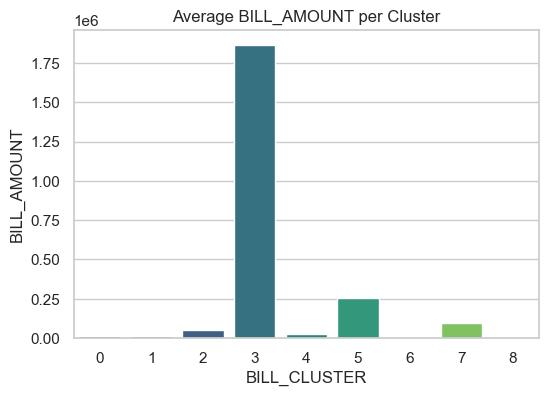

In [74]:
cluster_means = X_clusters.groupby("BILL_CLUSTER")["BILL_AMOUNT"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=cluster_means, x="BILL_CLUSTER", y="BILL_AMOUNT", palette="viridis")
plt.title("Average BILL_AMOUNT per Cluster")
plt.show()

This is a simple way to compare billing patterns across clusters. It helps identify which groups of customers or zones may need further investigation for anomalies or efficiency improvements.

In [75]:
X_clusters.groupby("BILL_CLUSTER")["BILL_AMOUNT"].mean()

BILL_CLUSTER
0    1.544029e+04
1    1.119340e+04
2    4.920370e+04
3    1.866827e+06
4    2.693389e+04
5    2.536370e+05
6    5.447248e+03
7    9.449536e+04
8    8.804484e+03
Name: BILL_AMOUNT, dtype: float64

<Axes: xlabel='BILL_AMOUNT', ylabel='Count'>

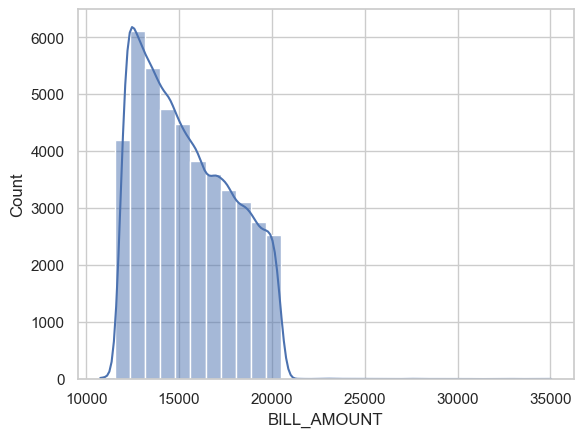

In [76]:
import seaborn as sns

cluster_0 = X_clusters[X_clusters['BILL_CLUSTER'] == 0]

sns.histplot(cluster_0["BILL_AMOUNT"], bins=30, kde=True)


This plot helps you understand billing behavior within a specific cluster and spot anomalies.

In [77]:
X_clusters['BILL_CLUSTER'].unique()

array([1, 6, 8, 7, 0, 4, 2, 5, 3])

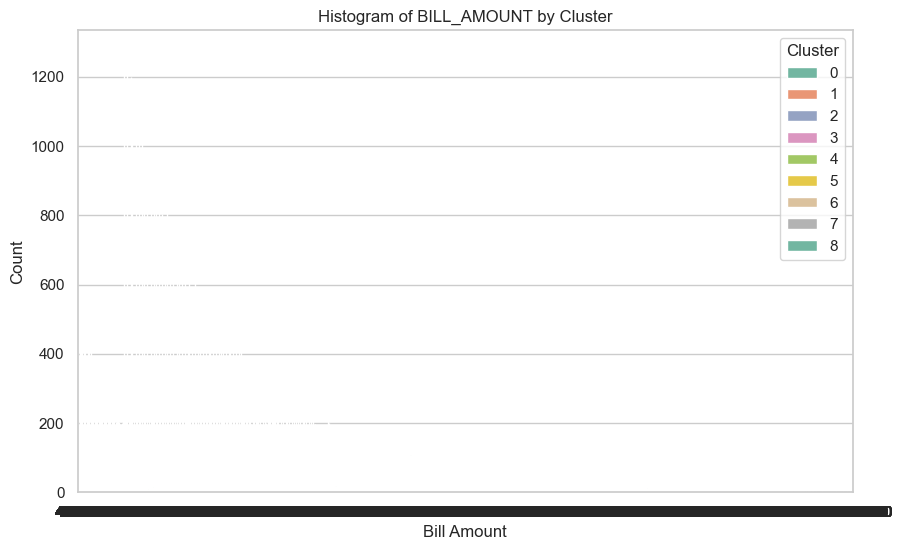

In [78]:
plt.figure(figsize=(10,6))
sns.countplot(data=X_clusters, x="BILL_AMOUNT", hue="BILL_CLUSTER", palette="Set2")
plt.title("Histogram of BILL_AMOUNT by Cluster")
plt.xlabel("Bill Amount")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.show()

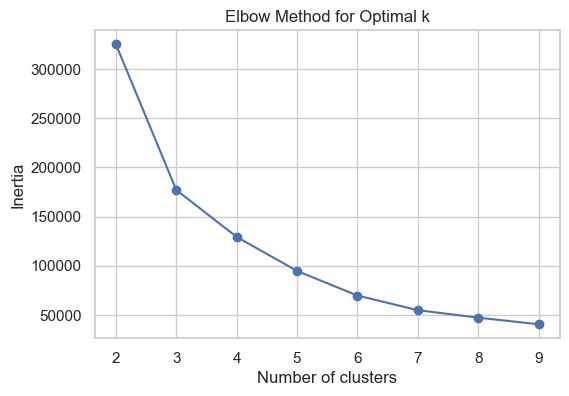

          BILL_VOLUME  WATER_AMOUNT  SEWER_AMOUNT
CLUSTER                                          
0          203.933994  1.479416e+04  7.683369e+03
1        18814.831135  1.286498e+06  4.959777e+05
2        71168.484848  5.692209e+06  3.841137e+06


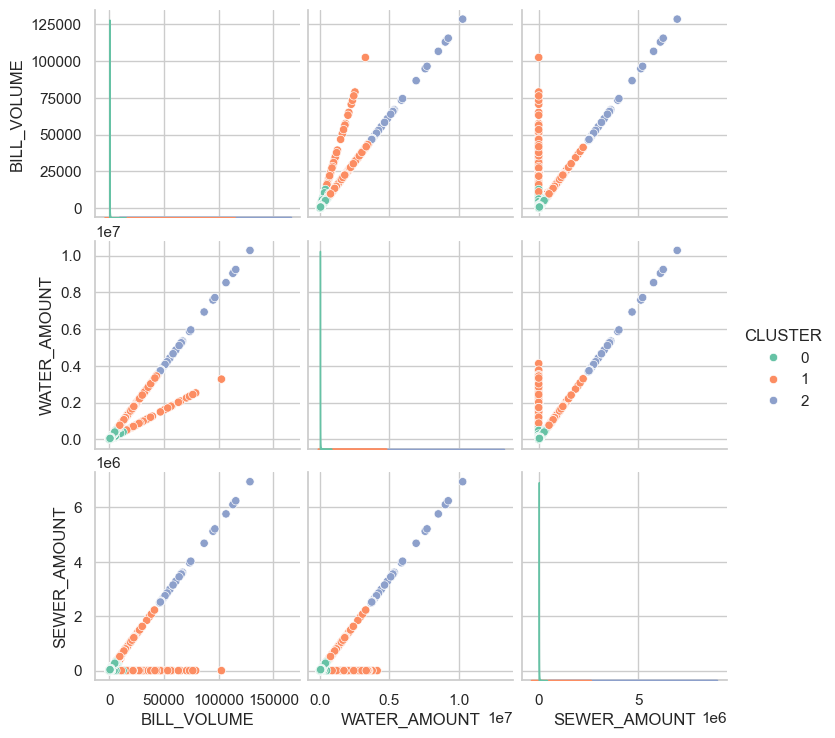

Potential abnormal clusters:
           BILL_VOLUME  WATER_AMOUNT  SEWER_AMOUNT
CLUSTER                                          
0          203.933994  1.479416e+04  7.683369e+03
1        18814.831135  1.286498e+06  4.959777e+05
2        71168.484848  5.692209e+06  3.841137e+06


In [81]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features to cluster on
features = ["BILL_VOLUME", "WATER_AMOUNT", "SEWER_AMOUNT"]
X = df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters (optional but recommended)
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# From the elbow plot, pick k (e.g., k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['CLUSTER'] = kmeans.fit_predict(X_scaled)

# Examine cluster statistics
cluster_summary = df.groupby('CLUSTER')[features].mean()
print(cluster_summary)

# Optional: visualize clusters
sns.pairplot(df, vars=features, hue='CLUSTER', palette='Set2')
plt.show()

# Identify abnormal clusters
# For example, clusters with very low billed volume vs water usage
abnormal_clusters = cluster_summary[cluster_summary["BILL_VOLUME"] < cluster_summary["WATER_AMOUNT"] * 0.8]
print("Potential abnormal clusters:\n", abnormal_clusters)


## **Predictive Modeling**


In [79]:
# Import Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb


In [86]:
# Prepare Data

# Select features
features = ["METER_SIZE", "REGION", "ZONE", "SUB_ZONE", "WATER_AMOUNT", "SEWER_AMOUNT"]  
target_reg = "BILL_VOLUME"  

# Fill missing values
df[features] = df[features].fillna(0)
df[target_reg] = df[target_reg].fillna(df[target_reg].median())

# Encode categorical features
categorical_cols = ["REGION", "ZONE", "SUB_ZONE"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scale numeric features for regression
numeric_cols = ["METER_SIZE", "WATER_AMOUNT", "SEWER_AMOUNT"]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Create classification target (High loss if BILL_VOLUME > 95th percentile)
df["High_Loss"] = (df["BILL_VOLUME"] > df["BILL_VOLUME"].quantile(0.95)).astype(int)


In [85]:
# split Data 

# Regression
X_reg = df[features]
y_reg = df[target_reg]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Classification
X_cls = df[features]
y_cls = df["High_Loss"]
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [87]:
#  Regresion Model

lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
y_pred_lr = lr.predict(X_test_reg)

print("Linear Regression MAE:", mean_absolute_error(y_test_reg, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test_reg, y_pred_lr))


Linear Regression MAE: 32.79035645904191
Linear Regression RMSE: 323.91446738461235
Linear Regression R2: 0.9266154333783994


In [88]:
# Random Forest Regressor  

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_reg, y_train_reg)
y_pred_rf = rf.predict(X_test_reg)

print("Random Forest MAE:", mean_absolute_error(y_test_reg, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test_reg, y_pred_rf))


Random Forest MAE: 7.235939747168014
Random Forest RMSE: 139.41447492258894
Random Forest R2: 0.9864056083741115


In [89]:
# classification
# logistic regresion

log = LogisticRegression(max_iter=500)
log.fit(X_train_cls, y_train_cls)
y_pred_log = log.predict(X_test_cls)

print("Logistic Regression Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print(classification_report(y_test_cls, y_pred_log))


Logistic Regression Accuracy: 0.9974655472833835
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       1.00      0.95      0.97      2167

    accuracy                           1.00     44191
   macro avg       1.00      0.98      0.99     44191
weighted avg       1.00      1.00      1.00     44191



In [90]:
# Random classifier

rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_cls, y_train_cls)
y_pred_rf_cls = rf_cls.predict(X_test_cls)

print("Random Forest Accuracy:", accuracy_score(y_test_cls, y_pred_rf_cls))
print(classification_report(y_test_cls, y_pred_rf_cls))


Random Forest Accuracy: 0.9988685478943676
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.98      0.99      2167

    accuracy                           1.00     44191
   macro avg       1.00      0.99      0.99     44191
weighted avg       1.00      1.00      1.00     44191



In [91]:
# XGboost Classifier

xgb_cls = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_cls.fit(X_train_cls, y_train_cls)
y_pred_xgb = xgb_cls.predict(X_test_cls)

print("XGBoost Accuracy:", accuracy_score(y_test_cls, y_pred_xgb))
print(classification_report(y_test_cls, y_pred_xgb))


XGBoost Accuracy: 0.9984159670521147
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42024
           1       0.99      0.98      0.98      2167

    accuracy                           1.00     44191
   macro avg       0.99      0.99      0.99     44191
weighted avg       1.00      1.00      1.00     44191



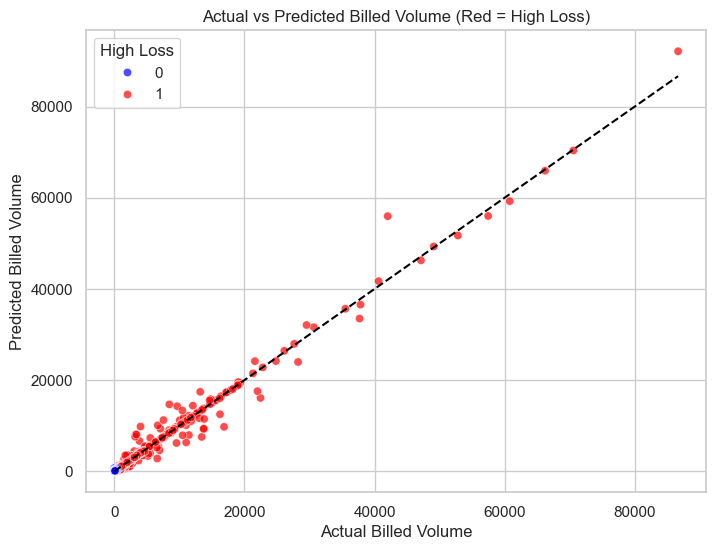

In [92]:
# Scatter Plot of Actual vs Predicted


import matplotlib.pyplot as plt
import seaborn as sns

# Add predicted values to the test set
df_test = X_test_reg.copy()
df_test["Actual_BILL_VOLUME"] = y_test_reg.values
df_test["Predicted_BILL_VOLUME"] = y_pred_rf
df_test["High_Loss"] = (df_test["Actual_BILL_VOLUME"] > df["BILL_VOLUME"].quantile(0.95)).astype(int)

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_test,
    x="Actual_BILL_VOLUME",
    y="Predicted_BILL_VOLUME",
    hue="High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
plt.plot([df_test["Actual_BILL_VOLUME"].min(), df_test["Actual_BILL_VOLUME"].max()],
         [df_test["Actual_BILL_VOLUME"].min(), df_test["Actual_BILL_VOLUME"].max()],
         color="black", linestyle="--")  # diagonal line for perfect prediction
plt.xlabel("Actual Billed Volume")
plt.ylabel("Predicted Billed Volume")
plt.title("Actual vs Predicted Billed Volume (Red = High Loss)")
plt.legend(title="High Loss")
plt.show()

Blue points = normal billed volumes

Red points = high-loss (top 5%)

The black dashed line = perfect prediction line (actual = predicted)

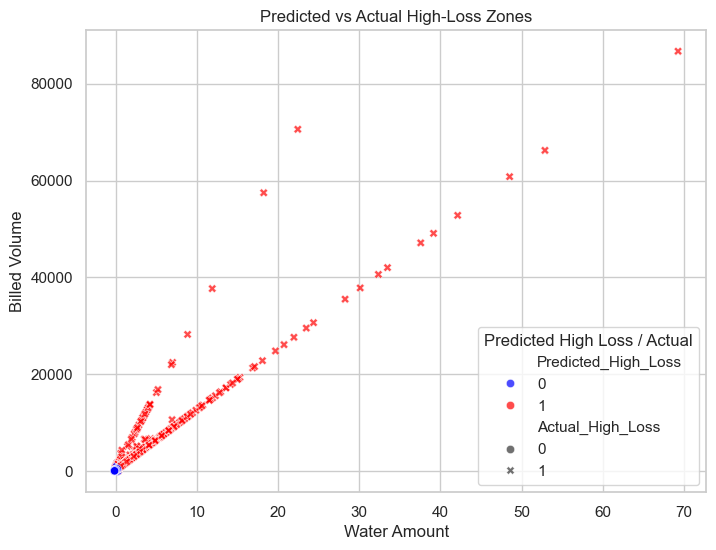

In [93]:
# Add classification predictions to the test set
df_test_cls = X_test_cls.copy()
df_test_cls["Actual_High_Loss"] = y_test_cls.values
df_test_cls["Predicted_High_Loss"] = y_pred_xgb

# Scatter plot using WATER_AMOUNT vs BILL_VOLUME for visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_test_cls,
    x=X_test_cls["WATER_AMOUNT"],
    y=y_test_reg.loc[X_test_cls.index],  # match actual billed volume for y-axis
    hue="Predicted_High_Loss",
    style="Actual_High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
plt.xlabel("Water Amount")
plt.ylabel("Billed Volume")
plt.title("Predicted vs Actual High-Loss Zones")
plt.legend(title="Predicted High Loss / Actual")
plt.show()


Color: Red = predicted high-loss, Blue = predicted low-loss

Marker style: Distinguishes actual high-loss vs low-loss points

This helps you quickly see false positives and false negatives, i.e., where the model misclassifies zones

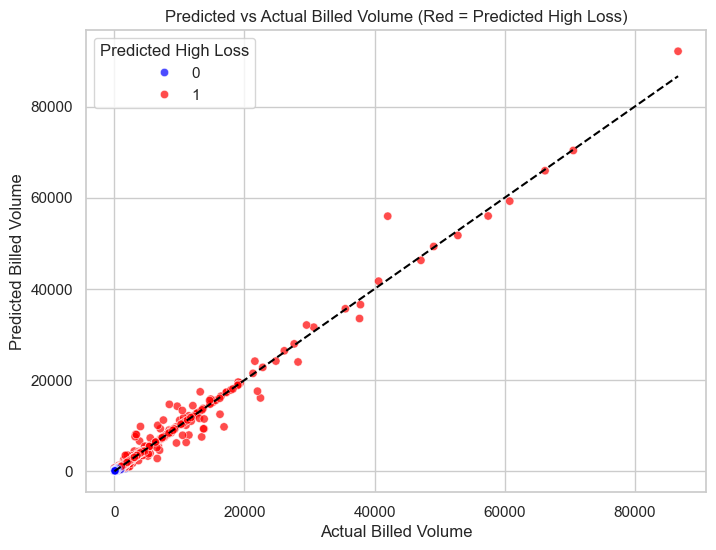

In [94]:
# Combine regression predictions and classification predictions
df_combined = X_test_reg.copy()
df_combined["Actual_BILL_VOLUME"] = y_test_reg.values
df_combined["Predicted_BILL_VOLUME"] = y_pred_rf
df_combined["Predicted_High_Loss"] = y_pred_xgb  # predicted by classification model

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_combined,
    x="Actual_BILL_VOLUME",
    y="Predicted_BILL_VOLUME",
    hue="Predicted_High_Loss",
    palette={0: "blue", 1: "red"},
    alpha=0.7
)
# Diagonal line for perfect prediction
plt.plot([df_combined["Actual_BILL_VOLUME"].min(), df_combined["Actual_BILL_VOLUME"].max()],
         [df_combined["Actual_BILL_VOLUME"].min(), df_combined["Actual_BILL_VOLUME"].max()],
         color="black", linestyle="--")

plt.xlabel("Actual Billed Volume")
plt.ylabel("Predicted Billed Volume")
plt.title("Predicted vs Actual Billed Volume (Red = Predicted High Loss)")
plt.legend(title="Predicted High Loss")
plt.show()


Red points: Zones predicted to be high-loss by XGBoost

Blue points: Predicted low-loss zones

Black dashed line: Perfect prediction reference